In [1]:
import pandas as pd
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datetime import datetime, timedelta

C:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
import os, sys
path_name= os.path.dirname(os.path.abspath(os.path.dirname(os.getcwd())))
sys.path.append(path_name)

In [3]:
from _element import feature_control as ft_c
from _element import varr
from _element import calculations as calc
from _element.result_control import Result

from _alg.prophet import Prophet_timeseries
from _alg.arima import Arima_timeseries

from _evaluation.cross_validation import Cross_Validation
from _evaluation import compare

In [4]:
INPUT_FILENAME= 'KPP일별회수(10_17)_withallobj.xlsx'

In [5]:
df_raw= ft_c.xlsx_opener(path_name+varr.DF_DIR, INPUT_FILENAME)
df_temp= ft_c.xlsx_opener(path_name+varr.TEMP_DATA_DIR, 'temp_data_merged.xlsx')

In [6]:
y_col= df_raw['raw'].columns.values.tolist()

In [7]:
try:
    y_col.remove('ds')
except ValueError:
    pass

In [8]:
x_col= df_temp['raw'].columns.values.tolist()

In [9]:
df_raw['raw']['ds']= pd.to_datetime(df_raw['raw']['ds'], box=True, format= '%Y/%m/%d', exact=True)
df_temp['raw']['ds']= pd.to_datetime(df_temp['raw']['ds'], box=True, format= '%Y/%m/%d', exact=True)
df_raw['raw']= pd.merge(df_raw['raw'], df_temp['raw'], how='inner', on='ds')

In [10]:
ft_c.add_division(df_raw, 'raw', 7, start_num= 3)

In [11]:
df_raw['raw']['seasonality_7,3']= df_raw['raw']['seasonality_7,3'].replace(to_replace= [0,1,2,3,4,5,6], value= ['mon','tue','wed','thu','fri','sat','sun'])

In [12]:
ft_c.divide_by(df_raw, 'raw', 'seasonality_7,3', div_set= {('mon','tue','wed','thu','fri'), ('sat',), ('sun',)})

In [13]:
for i in [('mon','tue','wed','thu','fri'),('sat', ),('sun', )]:
    ft_c.divide_multiple_y(df_raw, i, y_col, x_col, checkpoint= i)

In [14]:
df_raw

{"1025_('mon', 'tue', 'wed', 'thu', 'fri')":              ds   temp_max   temp_min  rain_amount    y
 0    2010-07-01  30.500000  24.900000          0.0    0
 1    2010-07-02  25.799999  22.700001         70.0  372
 4    2010-07-05  30.600000  21.799999          0.0   16
 5    2010-07-06  31.000000  22.400000          0.0  256
 6    2010-07-07  29.600000  21.900000          0.0   40
 7    2010-07-08  29.000000  21.299999          0.0   66
 8    2010-07-09  29.299999  21.799999          0.0  139
 11   2010-07-12  28.299999  22.200001          0.0   27
 12   2010-07-13  31.299999  21.900000          0.0   86
 13   2010-07-14  27.500000  22.700001          1.0  211
 14   2010-07-15  29.799999  24.299999          0.0    0
 15   2010-07-16  27.100000  21.700001         52.0  100
 18   2010-07-19  29.299999  24.200001          0.0   25
 19   2010-07-20  32.000000  26.700001          0.0   90
 20   2010-07-21  29.500000  26.000000          0.0  118
 21   2010-07-22  29.299999  24.500000      

In [15]:
for i, case_df in df_raw.items():
    df_raw[i]= ft_c.train_test_sample(case_df, 'y', x_col)

In [16]:
r= Result()

In [17]:
prpt_withobj= Prophet_timeseries(cv= True)

In [18]:
prpt_withobj.add_model('obj_result', 'day', regressor= False)

In [19]:
prpt_withobj.fit('obj_result', txs_traintest= df_raw)

In [20]:
prpt_withobj.forecast('obj_result', forecast_dict= r.forecast_dict)

C:\Studying\Project_Nextop\nextop-engine\nextop_engine\_alg\prophet.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  result_forecast['ds'], box=True, format= '%Y/%m/%d', exact=True


In [21]:
r.forecast_dict

OrderedDict([("obj_result_1025_('mon', 'tue', 'wed', 'thu', 'fri')",
              {'forecast':            ds  temp_max  temp_min  rain_amount  y      yhat
               0  2017-11-29       5.7      -3.2          0.0  0  0.000000
               1  2017-11-30       1.8      -7.1          0.0  0  0.000000
               2  2017-12-01       3.3      -4.9          0.2  0  1.556342
               3  2017-12-04       0.0      -8.1          0.0  0  0.000000
               4  2017-12-05      -2.1      -5.1          0.2  0  0.000000
               5  2017-12-06       3.6       0.4          1.3  0  0.052399
               6  2017-12-07       3.0      -6.1          0.0  0  5.564646
               7  2017-12-08      -2.1      -5.5          0.0  0  7.947973
               8  2017-12-11      -5.4     -13.2          0.0  0  0.000000
               9  2017-12-12      -6.6     -12.6          0.0  0  0.000000
               10 2017-12-13      -4.7     -11.1          0.0  0  1.037726
               11 2

In [22]:
r.merge_result(list(map(str, y_col)))
# list(map(str, y_col))

In [23]:
# r.err_rate()

In [24]:
# r.print_err_rate()

In [25]:
prpt_withobj._model.keys()

dict_keys(['obj_result', "obj_result_1025_('mon', 'tue', 'wed', 'thu', 'fri')", "obj_result_1041_('mon', 'tue', 'wed', 'thu', 'fri')", "obj_result_1091_('mon', 'tue', 'wed', 'thu', 'fri')", "obj_result_1127_('mon', 'tue', 'wed', 'thu', 'fri')", "obj_result_1216_('mon', 'tue', 'wed', 'thu', 'fri')", "obj_result_1242_('mon', 'tue', 'wed', 'thu', 'fri')", "obj_result_1261_('mon', 'tue', 'wed', 'thu', 'fri')", "obj_result_1355_('mon', 'tue', 'wed', 'thu', 'fri')", "obj_result_1373_('mon', 'tue', 'wed', 'thu', 'fri')", "obj_result_1375_('mon', 'tue', 'wed', 'thu', 'fri')", "obj_result_1376_('mon', 'tue', 'wed', 'thu', 'fri')", "obj_result_1396_('mon', 'tue', 'wed', 'thu', 'fri')", "obj_result_1627_('mon', 'tue', 'wed', 'thu', 'fri')", "obj_result_1656_('mon', 'tue', 'wed', 'thu', 'fri')", "obj_result_1692_('mon', 'tue', 'wed', 'thu', 'fri')", "obj_result_1729_('mon', 'tue', 'wed', 'thu', 'fri')", "obj_result_1745_('mon', 'tue', 'wed', 'thu', 'fri')", "obj_result_1754_('mon', 'tue', 'wed', '

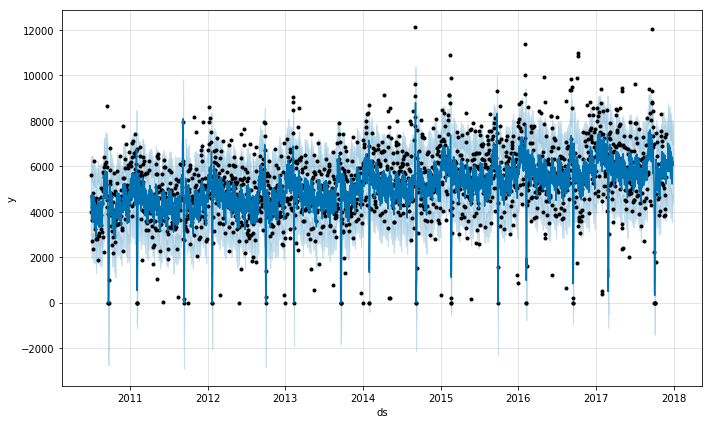

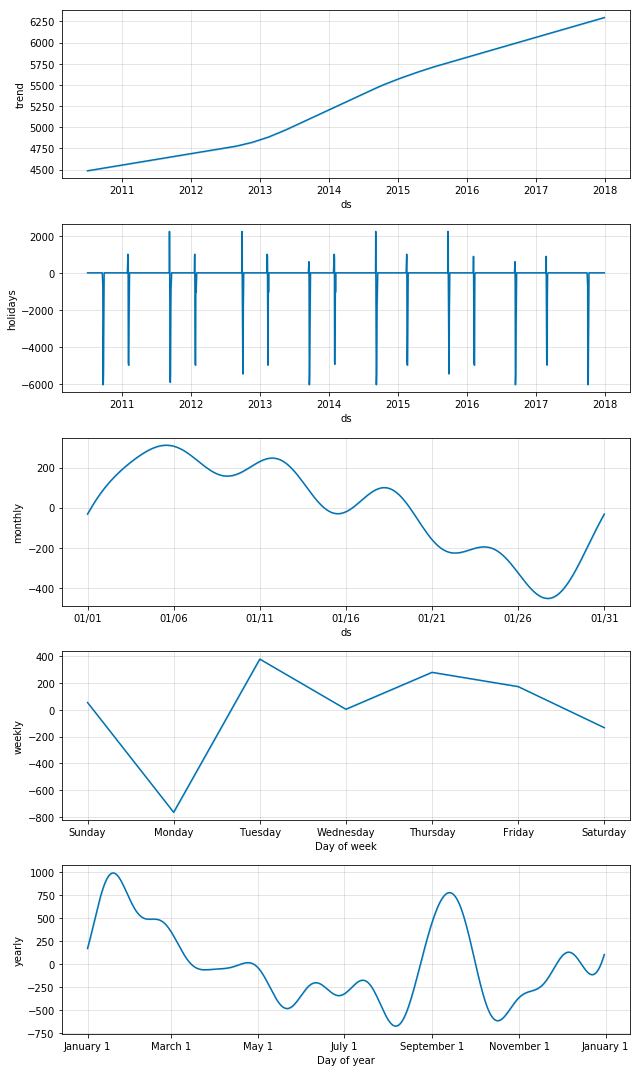

In [26]:
prpt_withobj.plot("obj_result_1878_('mon', 'tue', 'wed', 'thu', 'fri')")

In [27]:
ft_c.save_as_xlsx(path_name+varr.DF_DIR, r.forecast_dict, INPUT_FILENAME, '_제출용_180208')